In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def detect_lines(
    img,
    threshold1: int = 50,
    threshold2: int = 100,
    apertureSize: int = 3,
    minLineLength: int = 100,
    maxLineGap: int = 10,
):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  # convert to grayscale
    edges = cv2.Canny(
        gray, threshold1, threshold2, apertureSize=apertureSize
    )  # detect edges
    lines = cv2.HoughLinesP(
        edges,
        1,
        np.pi / 180,
        100,
        minLineLength=minLineLength,
        maxLineGap=maxLineGap,
    )  # detects lines

    return lines

In [3]:
def draw_lines(img, lines, color: tuple):
    for line in lines:
        x1, y1, x2, y2 = line[0]
        cv2.line(img, (int(x1), int(y1)), (int(x2), int(y2)), color, 2)

    return img

In [4]:
def get_slopes_intercepts(lines, height):
    slopes = []
    intercepts = []

    m_tol = 1e2
    dx_tol = 1e-3

    for line in lines:
        x1, y1, x2, y2 = line[0]

        if abs(x2 - x1) < dx_tol:
            dx = max(dx_tol, (x2 - x1)) if (x2 - x1 > 0) else min(-dx_tol, (x2 - x1))
        else:
            dx = x2 - x1

        if ((y2 - y1) / (1e6 * dx)) > 0:
            m = min(m_tol, (y2 - y1) / dx)
        else:
            m = max(-m_tol, (y2 - y1) / dx)

        b = x1 + (y1 / m)  # insert

        slopes.append(m)
        intercepts.append(b)

    return slopes, intercepts

In [5]:
def detect_lanes(lines, height):
    slopes, intercepts = get_slopes_intercepts(lines, height)

    m_tol = 15e-1
    b_tol = 6e2
    dm_min = 1e-2
    db_min = 1e2
    horizontal_tol = 1e3
    vertical_threshold = 5e2

    used = []
    lanes = []

    for i_0 in range(len(lines)):
        appended = False

        if (
            i_0 in used
            or (abs(1 / slopes[i_0]) > horizontal_tol)
            or (
                lines[i_0][0][1] < vertical_threshold
                and lines[i_0][0][3] < vertical_threshold
            )
        ):
            continue

        for i_1 in range(i_0 + 1, len(lines)):
            if i_1 in used or (1 / slopes[i_0] > horizontal_tol):
                continue

            if (
                abs(1 / slopes[i_1] - 1 / slopes[i_0]) < m_tol
                and abs(intercepts[i_1] - intercepts[i_0]) < b_tol
            ) and (
                abs(intercepts[i_1] - intercepts[i_0]) > db_min
                and abs(1 / slopes[i_1] - 1 / slopes[i_0]) > dm_min
            ):
                lanes.append([lines[i_0][0], lines[i_1][0]])
                appended = True

                used.append(i_0)
                used.append(i_1)

        if not appended:
            lanes.append([lines[i_0][0]])
            used.append(i_0)

    return lanes

In [6]:
def draw_lanes(img, lanes):
    lines = []

    for pair in lanes:
        for line in pair:
            lines.append([line])

    img = draw_lines(img, lines, (0, 255, 0))

    return img

In [7]:
def get_lane_center(lanes, x_center, height):
    center_lane = [[x.tolist()] for x in lanes[0]]

    if len(lanes) > 1:
        for pair in lanes[1:]:
            lane = [[x.tolist()] for x in pair]

            # Debug, wrong intercept(use bottom instead of top)
            slopes_0, intercepts_0 = get_slopes_intercepts(center_lane, height)
            slopes_1, intercepts_1 = get_slopes_intercepts(lane, height)

            m_0 = sum(slopes_0) / len(slopes_0)
            m_1 = sum(slopes_1) / len(slopes_1)

            b_0 = sum(intercepts_0) / len(intercepts_0) + (height / m_0)
            b_1 = sum(intercepts_1) / len(intercepts_1) + (height / m_1)

            if abs(b_1 - x_center) < abs(b_0 - x_center):
                center_lane = lane

    slopes, intercepts = get_slopes_intercepts(center_lane, height)
    m, b = (sum(slopes) / len(slopes), sum(intercepts) / len(intercepts))

    # return b, m
    return center_lane

In [8]:
def recommend_direction(center, slope, x_center):
    tol = 2e1

    difference = center - x_center

    if abs(difference) < tol:
        return "forward"
    elif difference > tol:
        return "right"
    else:
        return "left"

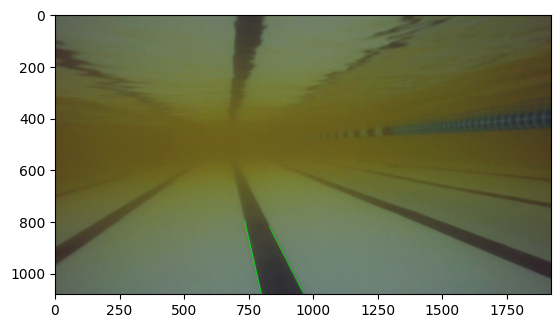

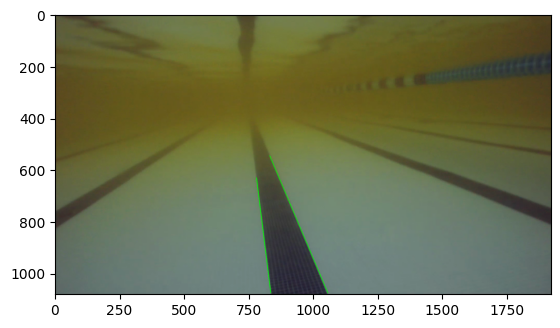

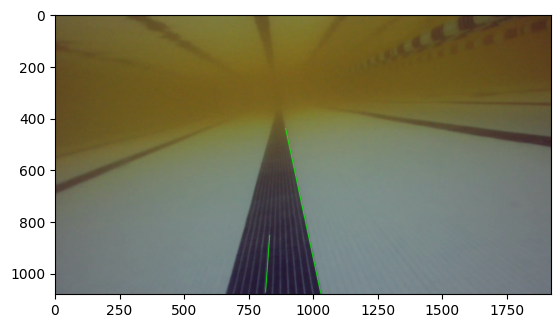

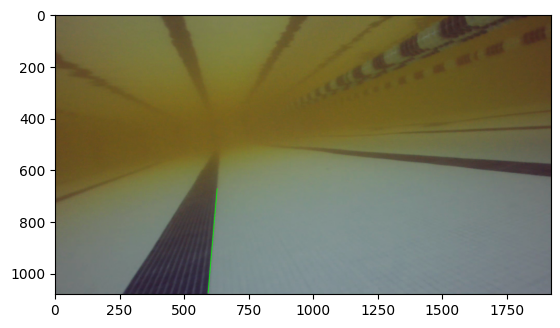

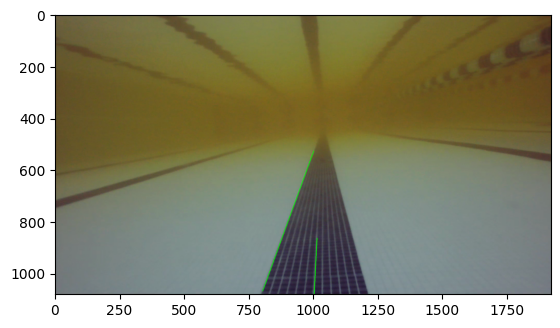

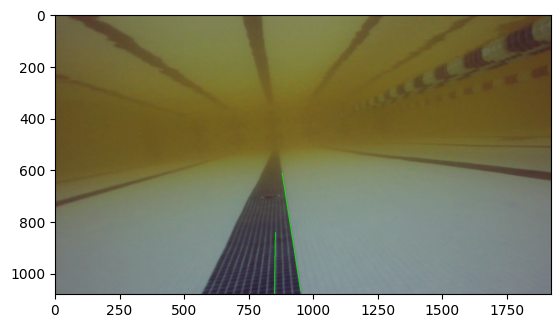

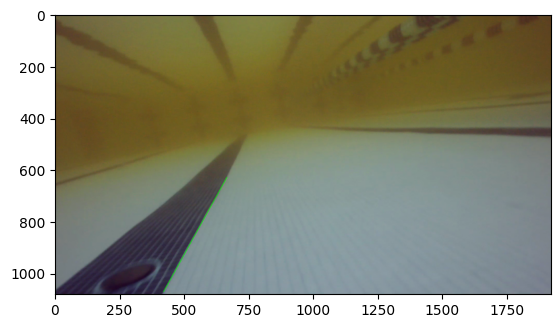

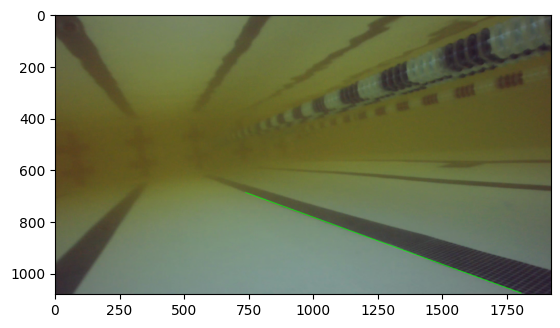

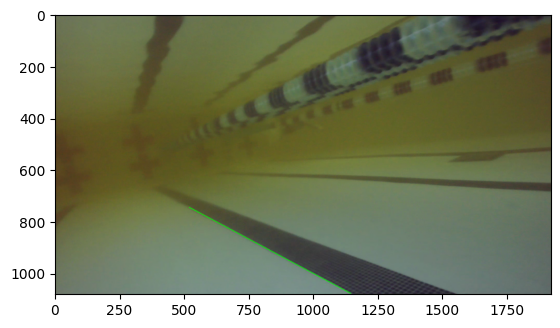

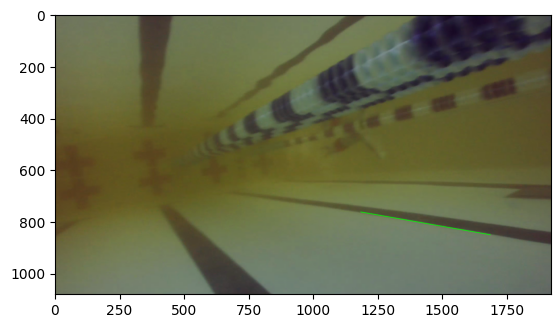

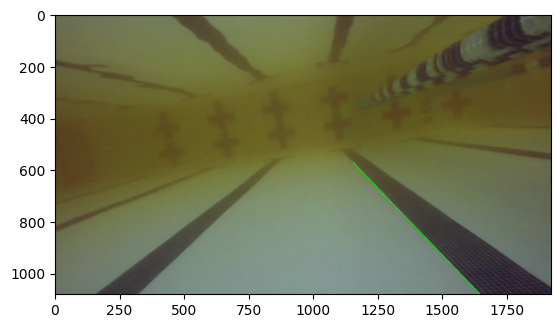

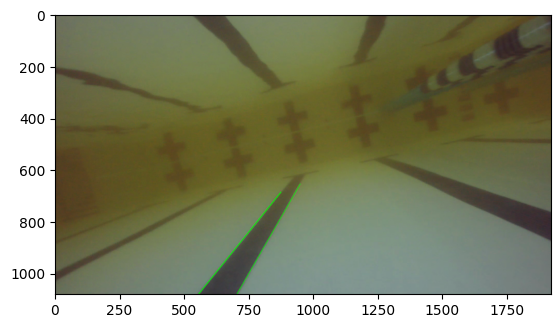

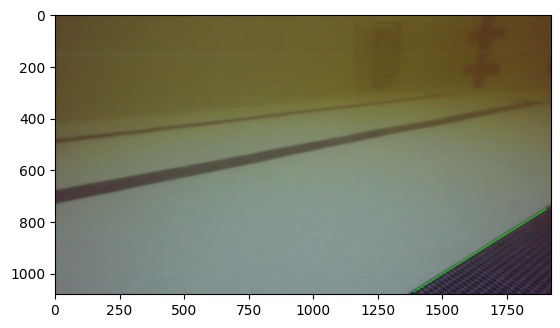

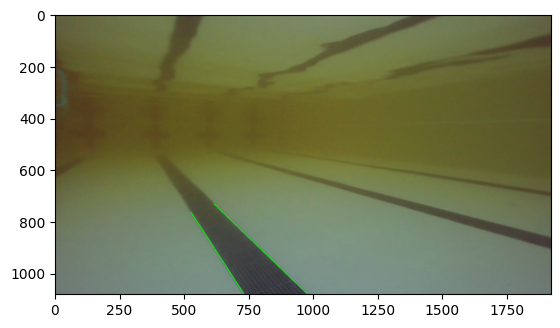

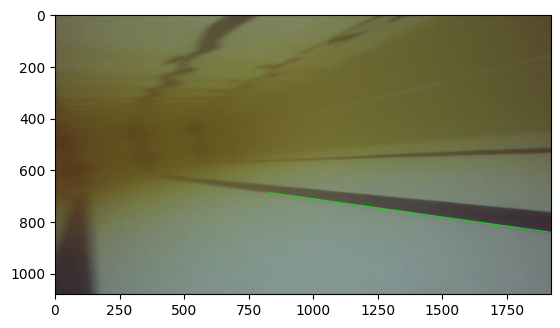

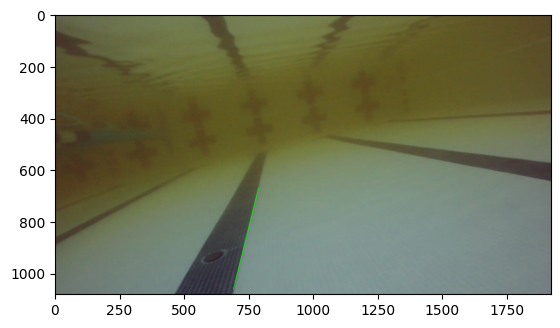

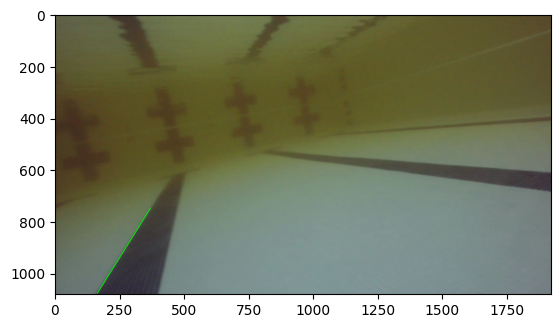

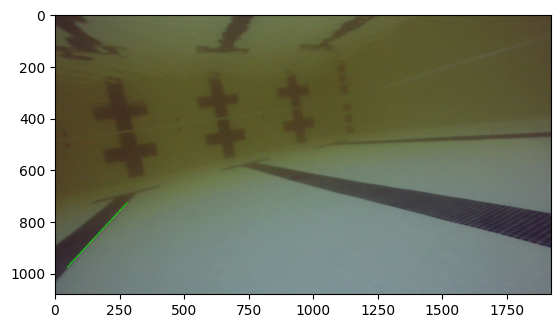

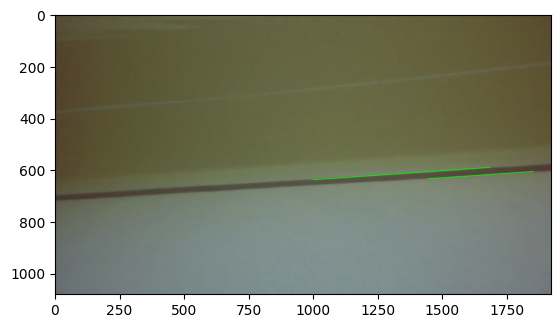

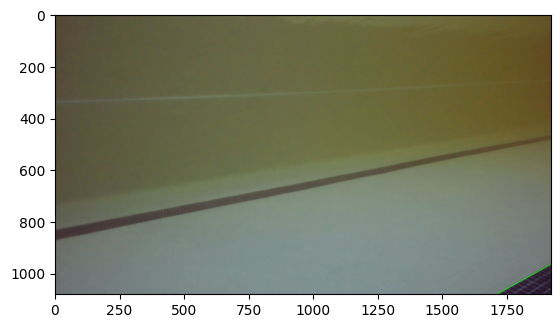

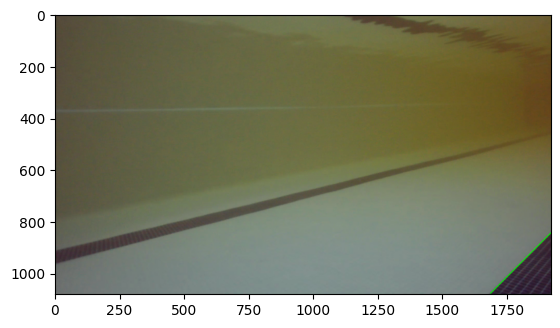

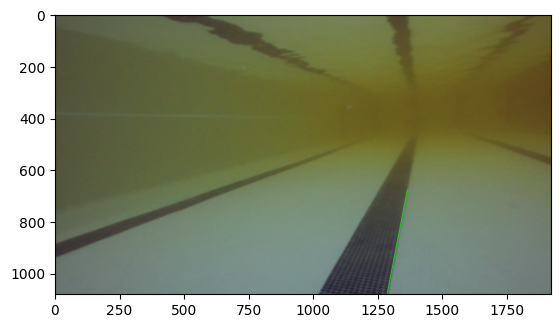

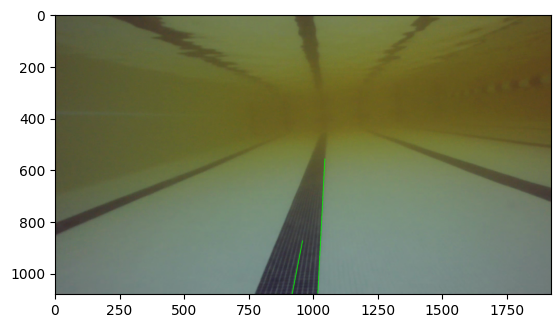

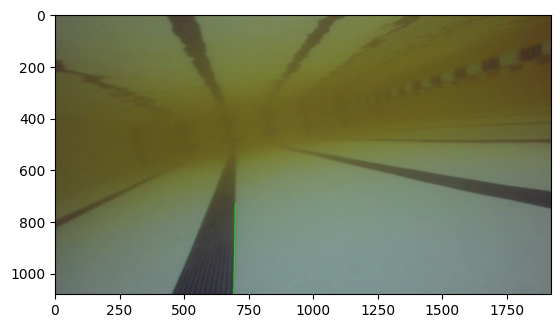

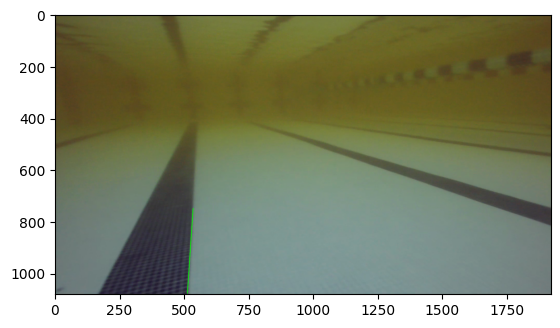

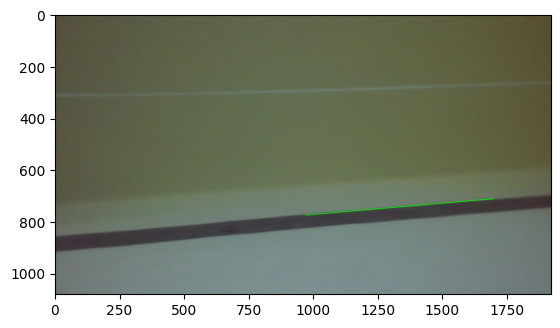

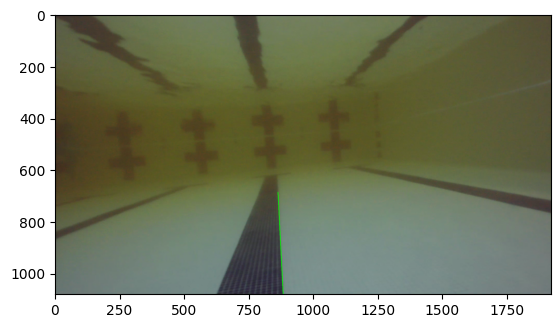

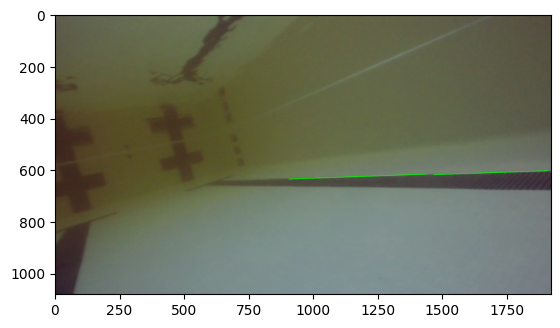

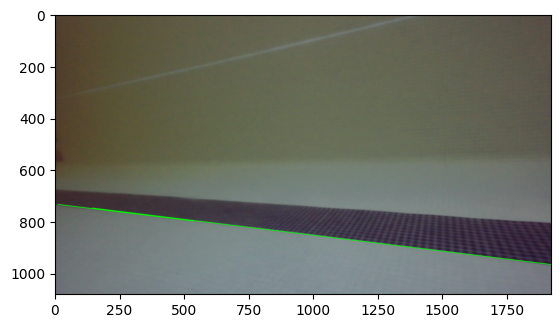

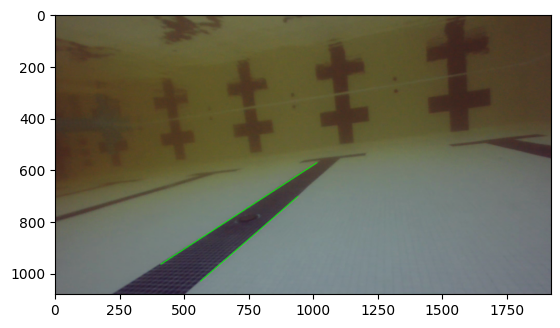

/tmp/ipykernel_4120/1789965179.py:21: RuntimeWarning: divide by zero encountered in scalar divide
  b = x1 + (y1 / m)  # insert
/tmp/ipykernel_4120/464283446.py:32: RuntimeWarning: divide by zero encountered in scalar divide
  abs(1 / slopes[i_1] - 1 / slopes[i_0]) < m_tol
/tmp/ipykernel_4120/464283446.py:19: RuntimeWarning: divide by zero encountered in scalar divide
  or (abs(1 / slopes[i_0]) > horizontal_tol)


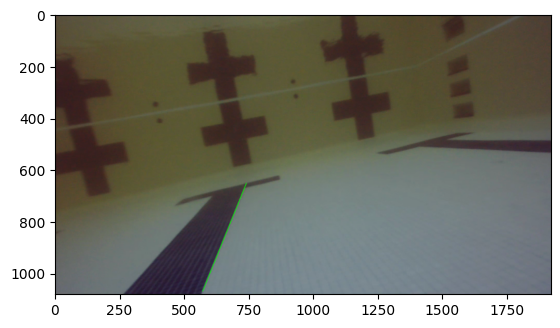

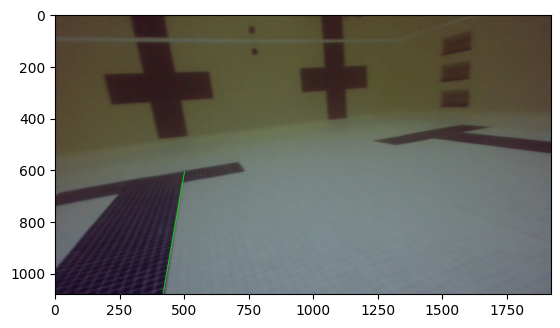

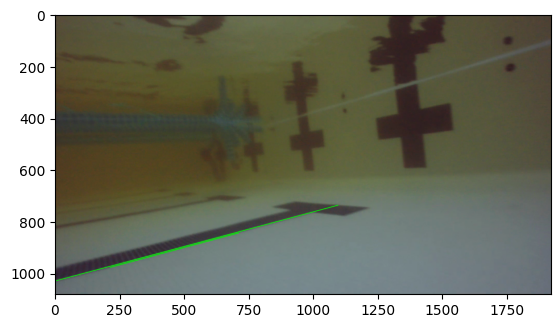

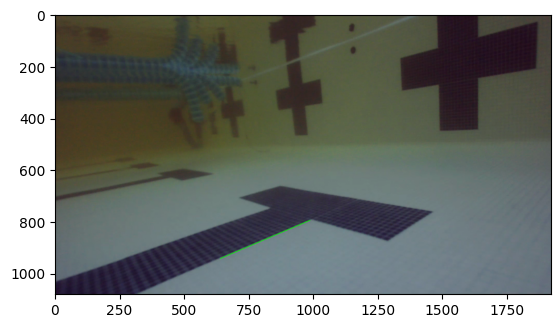

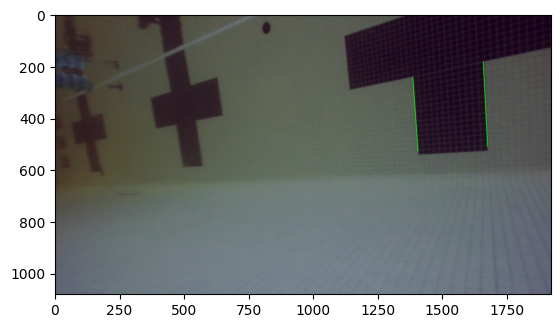

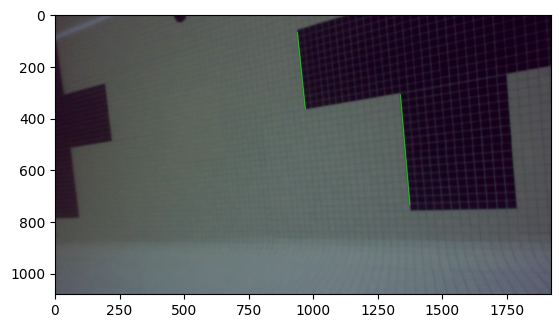

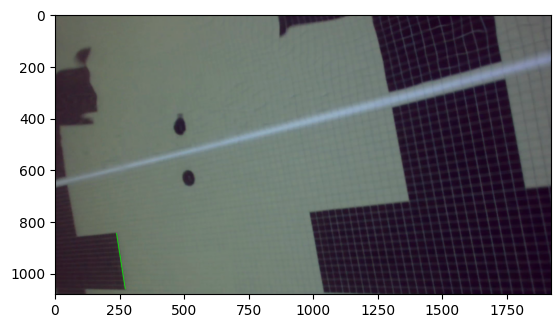

In [10]:
vcap = cv2.VideoCapture("AUV_Vid.mkv")

frequency = 60
count = 0

while True:
    ret, img = vcap.read()

    if not ret:
        break

    # img = draw_lanes(img, lanes)

    if count % frequency == 0:
        height = img.shape[0]

        lines = detect_lines(img, 50, 70, 3, 200, 100)

        # slopes, intercepts = get_slopes_intercepts(lines, height)

        lanes = detect_lanes(lines, height)

        # img = draw_lines(img, lines, (0, 255, 0))

        center_lane = get_lane_center(lanes, img.shape[0] / 2, img.shape[1])

        img = draw_lanes(img, center_lane)

        plt.imshow(img)
        plt.show()

    count += 1